## Import

In [ ]:
import os
import json
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

## Download data

In [ ]:
!gdown --id 1FvXfu1mE1UmcB-VlmCoj1MMB8yo5Svnm -O data.zip

Downloading...
From: https://drive.google.com/uc?id=1FvXfu1mE1UmcB-VlmCoj1MMB8yo5Svnm
To: /content/data.zip
884MB [00:09, 88.4MB/s]


In [ ]:
!unzip -qq data.zip

In [ ]:
!gdown --id 1Fqu90Yw55D2oOof7y_LwhXQhi-QaxX7p -O good.zip

Downloading...
From: https://drive.google.com/uc?id=1Fqu90Yw55D2oOof7y_LwhXQhi-QaxX7p
To: /content/good.zip
285MB [00:01, 144MB/s]


In [ ]:
!unzip -qq good.zip

In [ ]:
print(len(os.listdir('/content/good')))

1653


## Process data

In [ ]:
data_root_dir = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/'
os.mkdir(data_root_dir)
data_root_dir = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/'
os.mkdir(data_root_dir)
data_root_dir = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/train/'
os.mkdir(data_root_dir)

In [ ]:
def yolo_convert_to(bbox, w, h):
    width_bbox = bbox[2] * w
    height_bbox = bbox[3] * h
    x = bbox[0] * w
    y = bbox[1] * h
    x -= width_bbox / 2
    y -= height_bbox / 2
    return ' '.join(str(i) for i in [x, y, width_bbox, height_bbox, '\n'])

In [ ]:
train_img_path = '/content/data/images/train/'
train_txt_path = '/content/data/labels/train/'
train_img_list = os.listdir(train_img_path)
total_w = 0
total_h = 0
count = 0
for file_name in train_img_list:
    img = cv2.imread(train_img_path + file_name)
    height = img.shape[0]
    width = img.shape[1]
    total_w += width
    total_h += height
    name = file_name.split('.')[0]
    with open(train_txt_path + name + '.txt', 'r') as txt:
        res = ''
        labels = txt.read().split('\n')
        for row in labels:
            if row:
                count += 1
                if count % 1000 == 0:
                    print(count, end=' ')
                if count % 10000 == 0:
                    print()
                bbox = list(map(float, row.split()))
                res += yolo_convert_to(bbox[1:], width, height)
    with open(data_root_dir + name + '.txt', 'a') as txt:
        txt.write(res)
print(count)
print(total_w / count)
print(total_h / count)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 
11000 12000 13000 14000 15000 16000 17000 17124
136.97804251343143
110.98189675309507


In [ ]:
print(len(os.listdir(data_root_dir)))

3999


## Function

In [ ]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [ ]:
def bb_intersection(box_a, box_b):
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])
    t1 = xB - xA + 1
    t2 = yB - yA + 1
    if t1 <= 0 or t2 <= 0:
        intersection_area = 0
    else:
        intersection_area = (xB - xA + 1) * (yB - yA + 1)
    return intersection_area

In [ ]:
def bb_intersection_over_union(box_a, box_b):
    intersection_area = bb_intersection(box_a, box_b)
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    iou = intersection_area / (box_a_area + box_b_area - intersection_area)
    return iou

In [ ]:
def pyramid(image, downscale=1.5, min_size=(30, 30)):
    yield image
    while True:
        w = int(image.shape[1] / downscale)
        h = int(image.shape[0] / downscale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

In [ ]:
def non_max_suppression_new(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick]

In [ ]:
def non_max_suppression_2(boxes, overlap_thresh=0.7):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    return boxes[pick].astype("int")

## Get pos

In [ ]:
train_img_path = '/content/good/' #'/content/data/images/train/'
train_txt_path = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/train/'
train_img_list = os.listdir(train_img_path)
count = 0
for file_name in train_img_list:
    if file_name.split('.')[0] == '':
        continue
    # file_name = '000000000569.jpg'
    count += 1
    # if count == 500:
    #     break
    img = cv2.imread(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)
    i = 0
    for bbox in new_labels:
        if bbox[2] * bbox[3] > 1000:
            cv2.imwrite(os.path.join('/content/data_img/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]], (64, 128)))
            i += 1

In [ ]:
print(len(os.listdir('/content/data_img')))

4614


In [ ]:
!zip -r 'data_img_pos.zip' 'data_img/'

## Get neg

In [ ]:
train_img_path = '/content/good/' #'/content/data/images/train/'
train_txt_path = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/train/'
train_img_list = os.listdir(train_img_path)
count = 0
WINDOW_SIZE = (64, 128)
DOWN_SCALE = 1.5
STEP_SIZE = (64, 128)
for file_name in train_img_list:
    # file_name = '000000001799.jpg'
    if file_name.split('.')[0] == '':
        continue
    count += 1
    # if count == 250:
    #     break
    detection_list = []
    img = cv2.imread(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)

    # for bbox in new_labels:
    #     cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255, 0, 0), 2)
    # cv2_imshow(img)
    for (x, y, this_window) in sliding_window(img, STEP_SIZE, WINDOW_SIZE):
        h = this_window.shape[0]
        w = this_window.shape[1]
        flag = True
        for bbox in new_labels:
            iou = bb_intersection_over_union([x, y, x + w, y + h], [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            # print(iou, [x, y, x + w, y + h], [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            if iou > 0:
                flag = False
                break
        if flag == True:
            detection_list.append((x, y, w, h))
    i = 0
    for (x, y, w, h) in detection_list:
        cv2.imwrite(os.path.join('/content/data_neg/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(img[y:y+h, x:x+w],(64, 128)))
        i += 1

In [ ]:
train_img_path = '/content/good/' #'/content/data/images/train/'
train_txt_path = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/train/'
train_img_list = os.listdir(train_img_path)
count = 0
WINDOW_SIZE = (64, 128)
DOWN_SCALE = 1.5
STEP_SIZE = (47, 94)
for file_name in train_img_list:
    # file_name = '000000000328.jpg'
    if file_name.split('.')[0] == '':
        continue
    count += 1
    # if count > 5:
    #     break
    detection_list = []
    image = cv2.imread(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)
    scale = 0
    for im_scaled in pyramid(image, downscale = DOWN_SCALE, min_size=WINDOW_SIZE):
        # clone = im_scaled.copy()
        for (x, y, window) in sliding_window(im_scaled, STEP_SIZE, WINDOW_SIZE):
            if window.shape[0] != WINDOW_SIZE[1] or window.shape[1] != WINDOW_SIZE[0]:
                continue
            h = window.shape[0]
            w = window.shape[1]
            flag = True
            
            for bbox in new_labels:
                x_true = int(bbox[0] / (DOWN_SCALE ** scale))
                y_true = int(bbox[1] / (DOWN_SCALE ** scale))
                w_true = int(bbox[2] / (DOWN_SCALE ** scale))
                h_true = int(bbox[3] / (DOWN_SCALE ** scale))
                
                # cv2.rectangle(clone, (x_true, y_true), (x_true + w_true, y_true + h_true), (255, 0, 0), 2)

                iou = bb_intersection_over_union([x, y, x + w, y + h], [x_true, y_true, x_true + w_true, y_true + h_true])
                # print(iou, [x, y, x + w, y + h], [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
                if iou > 0.03:
                    flag = False
                    break
                    
            if flag == True:
                # cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
                detection_list.append((x, y, w, h))
            
        # cv2_imshow(clone)
        scale += 1
    i = 0
    for (x, y, w, h) in detection_list:
        cv2.imwrite(os.path.join('/content/data_neg_new/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(image[y:y+h, x:x+w],(64, 128)))
        i += 1
print(count)

1652


In [ ]:
print(len(os.listdir('/content/data_neg_new')))

59550


In [ ]:
!zip -r 'data_img_neg_new.zip' 'data_neg_new/'

## Train SVM

In [ ]:
from skimage.feature import hog
import joblib, glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm, metrics
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_data = []
train_labels = []
pos_im_path = '/content/data_img/'
neg_im_path = '/content/data_neg_new/'
model_path = 'models_well.dat'
# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.jpg")):
    fd = cv2.imread(filename, 0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(1)

# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(0)
train_data = np.float32(train_data)
train_labels = np.array(train_labels)
print('Train Data:',len(train_data))
print('Train Labels (1,0)',len(train_labels))
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)
model = LinearSVC(max_iter=6000)
print('Training...')
model.fit(X_train, y_train)
joblib.dump(model, model_path)
print('Model saved : {}'.format(model_path))

Train Data: 64164
Train Labels (1,0) 64164
Training...
Model saved : models_well.dat


In [ ]:
print('Train Data:',len(train_data))
print('Train Labels (1,0)',len(train_labels))
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)
model = LinearSVC(max_iter=8000)
print('Training...')
model.fit(X_train, y_train)
joblib.dump(model, model_path)
print('Model saved : {}'.format(model_path))

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9136962417667571
Precision: 0.6120591581342435
Recall: 0.4944852941176471


In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9383896103896104
Precision: 0.5950155763239875
Recall: 0.4185536888239591


## Testing

In [ ]:
from skimage import color
from imutils.object_detection import non_max_suppression

PennPed00041.png
sc:  [0.169842752670314, 0.5966749669550054, 0.4643299673743776, 0.6963861623518642, 0.207311983210564, 1.4340382262358151, 0.9580706518985581, 0.11466195883662833, 0.39439629454913827, 0.13605044328290938, 0.3528687354010286, 0.26806935603944415, 0.35152606483714244, 1.0177064883929523, 0.6426598380105947, 1.3938773232333825, 0.6051653787078916, 0.2083784457120773, 0.12755139351028333, 0.2282561833207174, 0.2654283406733161, 0.21049115860917877, 0.9313269918178942, 0.4421492073917578, 0.7060476943260966, 0.4612717823479594]


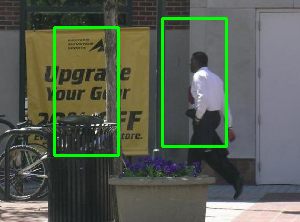

PennPed00090.png
sc:  [0.25162319264169575, 0.3233380380379117, 0.401244526465948, 1.9722177062281152, 0.5655127438760882, 1.282340119575169, 1.383233165540792, 1.5880782835545753, 0.3173334640099198, 0.6763423672485634, 0.8338611637771353, 0.32250681895729805, 0.1917869015394701, 0.266829957934, 0.19063879825990615, 0.3516782577394387]


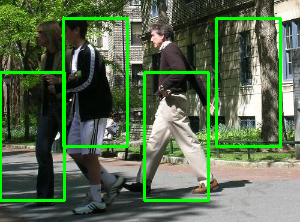

PennPed00033.png
sc:  [0.8250144443479283, 0.16055208902049733, 0.7075037155571332, 0.8831125809443069, 1.022418890271478, 0.25059261744483863, 0.2489482237930668, 0.45245083192523794, 0.16277048809823735, 0.44861006622528155, 0.1298132609753685, 0.30291393675738754, 0.18611439163471888, 0.7633000282088981, 0.4973808822919715, 1.0603273933148576, 0.31066777211123886, 0.27008135839915115, 0.6057568540314072, 0.15100879962793023, 0.5813751966230266, 0.7025077190650172, 0.4912756040454441, 0.2596454141167267, 0.7141354196038888, 0.5167886863891648, 0.214505156614048, 0.10757745223666404, 0.34290826938284413, 0.5762497392830795, 0.6921573604852017, 1.0122244532359046, 0.3558107664441982, 0.7385852624816819]


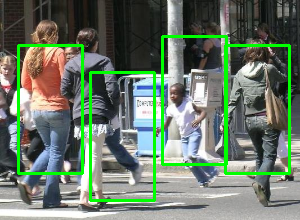

PennPed00036.png
sc:  [0.5161749989995906, 0.11490454443374853, 0.19875465383760182, 0.21628204159249032, 0.6365404892530472, 0.5578203481670571, 1.4165317514910027, 0.21791138806169463, 0.35355971569265654, 1.6268649101953359, 0.10163591705157138, 0.1795131335976311, 0.5405584184483198, 1.7462035297529672, 0.5626053866561976, 0.7049079863946389, 0.6232643780912007, 0.2861682302053504, 0.1702688811851677]


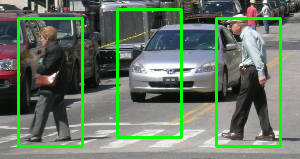

FudanPed00073.png
sc:  [1.851858535882525, 1.470463015206235, 0.3952751413355152, 0.8092950225879235, 0.27601946176313874, 0.8247191776404316, 0.6069135725117, 0.8247434686421456, 1.4092522091844035, 1.3850358051285587, 0.1207524433349706, 0.23035256935482018, 0.4716913441670515, 0.4950550861087121, 0.1107053208865626, 0.4645076059052319, 1.5931966991170565, 0.4239272441012031, 1.7779015043133861, 0.29830302953457266, 0.5028082485233788, 0.5054739413983184, 0.8371892275639353, 2.137334481592505, 0.38514828811990565, 0.7511305590196017]


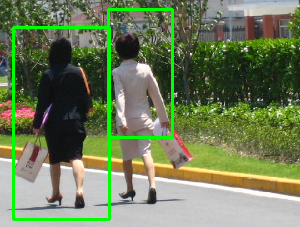

PennPed00019.png
sc:  [0.47317077920903816, 0.47061909805013, 0.3474141571485575, 0.6020204627456663, 0.13762877019264852, 1.3924349315591242, 1.3684066647624338, 1.1437058830975815, 0.25464290939153045, 0.19517159912953053, 0.5663089910801028, 0.1588574781213431, 0.4863909712211697, 1.0185178750299904, 0.23059312451280334, 0.5922188772958158, 0.3602813183190806, 1.6249618869446452, 1.4632752839065244, 2.591635449951864, 0.9109734089001323, 0.3738385798119307, 0.5780163266659734]


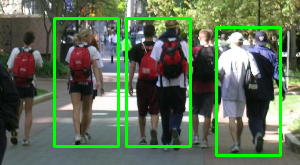

PennPed00018.png
sc:  [0.5911449241789201, 0.7123369639382012, 0.6647969376899764, 0.5022868898705951, 0.25687752292442856, 0.94301054933999, 0.13608754845418247, 0.17148746540103776, 0.17010629441114944, 0.18670066112723005, 0.16966255155175347, 0.4361059299339157, 1.4166624078178458, 0.5571066552778866, 0.4202894716776123, 0.2925190463774493, 0.15598516466375922, 0.6884000358547321, 1.2961238856881727, 0.7864501600075456, 0.3600031535619369, 1.0967454958181753]


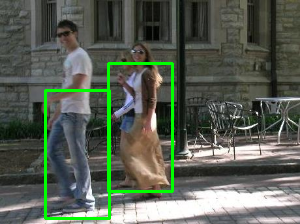

FudanPed00025.png
sc:  [1.0145812103571026, 0.30491821914918893, 0.3691864502709229, 0.34992107419532437, 0.5027314984632155, 0.20602291414596163, 0.7067040335739739, 0.14481461021219488, 0.6127130360197223, 0.569173789185255, 0.15051098840894073, 0.24347949886258735, 1.2288313698422622, 0.31290461730642216, 0.18124134162183825, 0.3752461583443153, 0.41497869539826937, 1.0271795362264946, 0.7206928385405099, 0.21990809426069957, 0.5385279914497493, 0.6497895194050788, 0.28675924899303296, 0.5760084279381515, 0.4328640075306981, 1.4381116126209523, 0.4382712493541706, 0.42405310808377117, 0.19299633170669728, 0.9582493001280977, 0.6281719062150949, 0.19635389854395224, 0.42003065500043235, 1.0624422045895057, 0.45847498520531327, 0.5011891867453736, 0.6273631814202539, 0.218033484383933, 0.7808834693895753, 0.11196189834491477, 0.2109763182797345, 0.37389234058571674, 0.367710853190354, 0.13495620769972605, 1.1388284026751951, 0.7318185395863729, 0.41000277285047904, 0.3693230081866147]

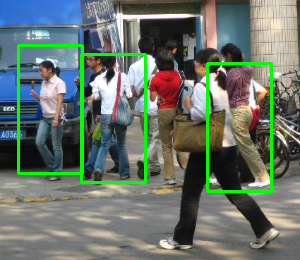

FudanPed00055.png
sc:  [0.4526898695474809, 0.2876359765909787, 0.3474976474505861, 0.5195744651082833, 1.157515755624273, 0.3588923118884281, 0.5358952241585123, 0.38648752819935417, 0.3095080800364739, 0.13711013989429988, 0.420602803121365, 0.8873750503625258, 0.5516482389344611, 1.3457870090907051, 0.3203856674376816, 0.44161341414138244, 1.165294449472825, 0.10642436378188636, 0.10079077121675029, 0.10809340045711757, 0.5969269217414651, 0.3549360168302568, 0.31925728844479206, 0.2034351772277917, 0.1817436124648143, 0.3627930184755864, 0.11065816033575337, 0.3476565266311228, 0.2701678679791132, 0.863597404833505, 0.7463825117763824, 0.5071564775099863, 0.7953284809247775, 0.2493115377870273, 0.6583958021410731, 0.1554365465577353, 0.5915413588857322, 0.5528270028851173, 0.5490389568786253, 0.17043425407777424, 0.27795238160801683, 0.5062865399832138, 0.70691373453664, 0.798965820005871, 0.7882049865349557, 1.368678124495628, 0.2406700495833557, 0.6349966891952844, 1.261475515198

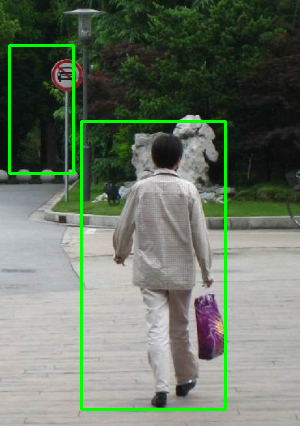

PennPed00070.png
sc:  [0.4508678537968903, 1.0975607489911843, 0.6157515886112753, 0.873808029682826, 1.7407937798340485, 0.5690873443240839, 1.0685818991593075, 0.17547471317567898, 0.27029830720850334, 0.6341240733623442, 0.1628484296274545, 0.14286048678146435, 0.4760169796800219, 0.4099689422644127, 0.3513541731895954, 0.38663520544849417, 0.8823970778355018, 0.771209751498429, 0.28663566413408825, 0.6352421008673285, 1.3319728623453218, 0.8749156492373616, 0.22166313445416208, 0.9305182581957171, 0.21594046416500834, 0.2915982322467213, 0.3367841401270034, 0.39589621646166384, 0.7059139176188195, 1.2637945535008277, 0.21882744252976927, 0.4791138224446275, 0.12585617949673245, 0.4909830999860846, 0.3753799441172062, 0.5563754126693653, 0.6318179876957376, 1.1060618187616447, 0.6976139486437013, 0.3925970850391066]


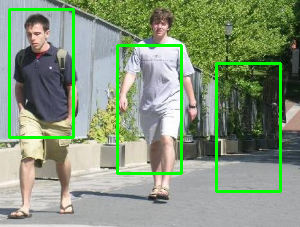

PennPed00005.png
sc:  [0.3277765479296989, 0.10910767861263448, 0.9186869088830992, 0.6127945386801475, 0.15832029752079146, 0.5859581467151184, 0.7122199167558573, 0.2703214235924677]


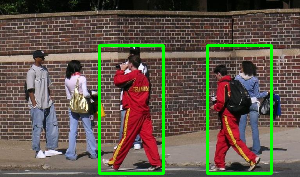

PennPed00025.png
sc:  [0.17740632890970176, 0.3462451149807041, 0.19245460302091366, 0.6801710024593967, 0.22825310585402458, 0.9183872361169344, 0.2750789562200654, 0.43237858790117156, 0.30354887765065774, 0.24633345056376055, 0.5411589015321095, 0.6690076596852245]


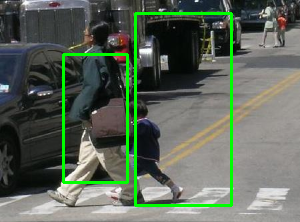

PennPed00073.png
sc:  [0.21521520910533953, 0.9936632472159209, 0.7312005850166711, 0.5172878864677332, 0.3789805399736407, 0.16530301064080233, 0.6103169989270499, 0.18125032662446794, 1.3362390011737393, 0.5010183950504353, 1.1734384709884549, 1.525560181549209, 0.44954623774384317, 0.30897778938005505, 0.4558375179879196, 0.11538247482395103, 0.1566262251284648, 0.37839632494049125, 0.12517547959541198]


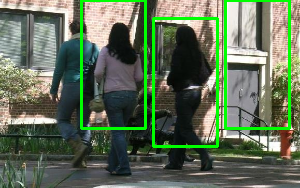

FudanPed00064.png
sc:  [0.17957676366382735, 0.23390750675921967, 0.6813280628473736, 0.8556576102012093, 0.682362371895462, 0.4974818809553193, 0.9868652607334233, 0.1335615312895927, 0.12244045907983925, 0.21973502854013727, 0.10463054636140823, 0.19420717655511377, 0.1673404839477014, 0.6309517783538016, 0.41499437344544876, 0.17503522826115792, 0.10328543365377107, 0.4191311215841552, 1.0962665734298955, 0.8126960125407362, 0.1549818930472301, 0.4180709939586714, 0.25766616396098374, 0.7007150928794709, 0.6844756363387502, 0.8902540562344937]


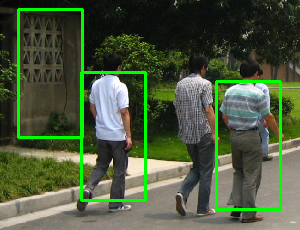

FudanPed00037.png
sc:  [0.1539219546695364, 0.19474123264187282, 0.2479769558545718, 0.2978360926816198, 0.47541246806509097, 0.4816453807481459, 0.23734105438179365, 0.23661328989454933, 0.2845284913585667, 0.49226109940215756, 0.39410608516853374, 0.5520211289518707, 0.2660939985183738, 0.404055550258528, 0.4537951068569658, 0.4765149151641118, 0.9398964780387767, 0.20066567279959713, 1.9181523952738724, 0.9193971452218023]


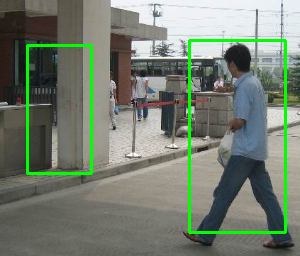

PennPed00048.png
sc:  [0.9042937668181253, 0.7287013899631208, 0.7166453244284795, 0.8528783179212637, 0.7158649003627332, 0.7978317336853052, 0.9017160786258201, 1.5174977281779887, 0.5716276553260319, 0.3358010806264201, 0.23216684699882995, 0.22183756543146582, 0.18424087060684224, 0.7548681543157999, 0.161759325194884, 0.3550188492260512, 0.28089576037421915, 0.3706165247512577, 1.29374353812383, 0.25207527157801135, 0.4565558939638238, 2.4104830831035913, 1.845319699808475, 0.2141390296911917, 0.245588776942398, 0.9151849846754861, 0.21811578900722017, 0.4505901525323027, 0.4374182827539884, 1.062699503991892, 0.8211889230165376, 0.5606174377741603, 0.8034864297459977, 0.1959904949585337, 0.9036568474971677, 0.26621282175261907, 0.3691016841213913, 0.6517617941990185, 0.8309570707499138, 0.8037326325148492, 0.7066890007614358, 0.16372275488456134, 0.6239989106479215, 1.2722749836270277, 0.5717595254970415, 0.7141567530441278, 1.1447351000744272, 0.3051859721500255, 0.7332039868979

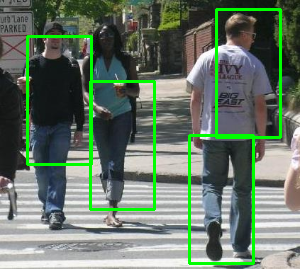

PennPed00081.png
sc:  [0.7532171045352901, 0.5975311566356406, 0.20763832789931447, 0.31208127529437457, 0.10973092883626212, 0.12725742600547452, 0.674042096311788, 0.10060560635920035, 0.20353445580811658, 0.6345567896441656, 0.2426846272588451, 0.31588825750744653, 0.47783702940653827, 0.2248418017492736, 0.6116878437277359, 0.23188397924269422, 0.12893624646586754, 0.26599888525745585, 0.5634751993657307, 0.2624304125678515, 0.22171648741123995, 0.13042698306195388, 0.4168757949863374, 0.19713030007826104, 0.31346388982157214, 0.456324607774376, 0.3434869727802302, 0.14200732231021906, 0.13170689377863554, 0.30869808264056176, 0.35594318539118974, 0.11426633757811955, 0.610724846109319, 0.768254171378809]


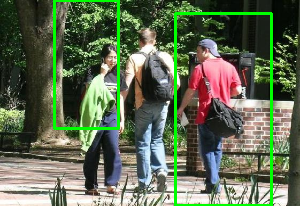

FudanPed00014.png
sc:  [0.1701083853791957, 0.30631780468572256, 0.2628136364412509, 0.1317198454872398, 0.5470145438351547, 0.786298388984417, 0.5972892515234641, 0.34090244391955127, 0.1266485644967449, 0.8347376011539097, 0.7303886384324171, 0.43917494599192375, 0.17460129874178076, 0.43803854932906094]


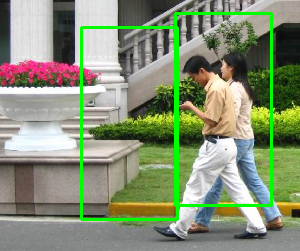

PennPed00087.png
sc:  [0.11404437520094957, 0.5662935986924714, 0.48397818724817376, 0.1737273267449636, 1.3698600626595825, 0.1305034255977865, 0.20781552201184128, 0.23836005986671316, 0.1916699535424854, 0.4946477005228972, 0.13095794928727578, 0.47491804487128386, 0.7560800128172075, 0.42707360680883466, 0.7484424323503281, 0.39172291646583146, 0.2762610663524697, 0.1546778942847561, 0.2956432361951301, 0.41537702564791223, 0.725651545235603, 0.35356247329432067, 1.9160979869630448, 0.7171754488382706, 0.2876852785956908, 0.8894067197244565, 0.988159384857897, 0.24055592158625816, 0.1453362384791036, 0.17237919494280007, 0.10730004611422383, 0.2942066354674596, 0.35573364456032197, 0.32559364555808756, 0.4767114417429853, 1.4418903041605673, 0.18939253798369482, 0.3644656776044931, 0.13284160750544471, 0.2773609923837784, 0.3872508077952942, 0.2188599519867055, 0.15448836937390797, 0.5731875918345798, 0.42121685530394715, 0.10776028123346915, 1.0026481566319, 0.4380007765040944, 0.

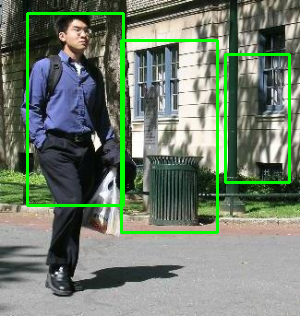

FudanPed00068.png
sc:  [0.3129781784351625, 0.10890225315023294, 0.15700391708576367, 0.5055873307803117, 0.42221237252906996, 0.551773895604938, 1.0290493649030235, 0.3220269999655031, 0.5701801243855583, 1.0416814069425446, 0.6883021447263579, 0.5526943544018247, 0.7738107626738625, 0.39857632830906986, 0.2006637167673876, 0.700092280190776, 0.29082241761878425]


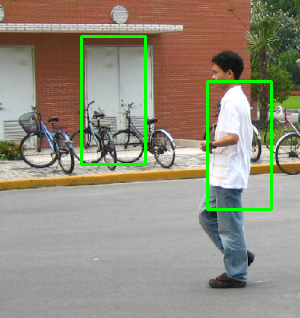

FudanPed00044.png


In [ ]:
# test_dir = '/content/data/images/val/'
test_dir = '/content/PennFudanPed/PNGImages/'
# test_dir = '/content/good/'
test_list = os.listdir(test_dir)
count = 0
for file_name in test_list:
    print(file_name)
    # file_name = '000000006074.jpg'
    # file_name = 'qq.jpg'
    count += 1
    if count > 20:
        break
    image = cv2.imread(test_dir + file_name)
    img_W = 300
    image = cv2.resize(image,(img_W,int(image.shape[0]*img_W/image.shape[1])))
    size = (64,128)
    step_size = (9, 9)
    downscale = 1.5
    #List to store the detections
    detections = []
    #The current scale of the image 
    model = joblib.load('models_well.dat')
    scale = 0
    for im_scaled in pyramid(image, downscale = downscale, min_size=size):
        for (x, y, window) in sliding_window(im_scaled, step_size, size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)
            fd = hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            if pred == 1:
                if model.decision_function(fd) > 0.1:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                    int(size[0] * (downscale**scale)),
                    int(size[1] * (downscale**scale))))
                    # detections.append([x, y, model.decision_function(fd), size[0], size[1]])
        scale += 1
    clone = image.copy()
    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    print ("sc: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.03)
    for(x1, y1, x2, y2) in pick:
        cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # cv2.putText(clone,'Person',(x1-2,y1-2),1,0.75,(121,12,34),1)
    cv2_imshow(clone)

FudanPed00025.png
sc:  [0.5024603265341409, 0.7112664652303079, 0.76300525394884]


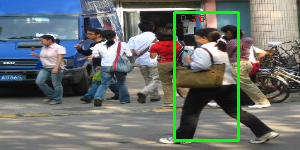

FudanPed00060.png
sc:  []


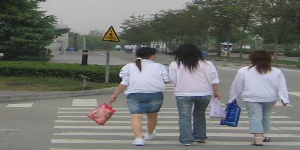

PennPed00016.png
sc:  [0.41293856493038994, 0.4405399370919513, 0.47579589292381363, 0.502142129094001, 0.5282399558059329, 0.6205524592477895, 0.8479859696867244, 0.958835660012655, 0.9603161952198965]


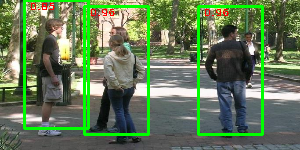

FudanPed00017.png
sc:  [0.46724261201249473, 1.0296568175296148]


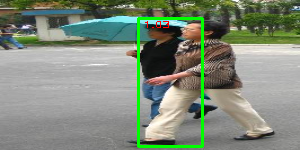

FudanPed00074.png
sc:  [1.1028094318830797]


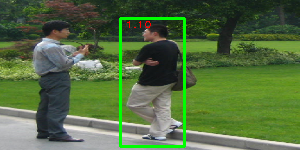

PennPed00038.png
sc:  [0.5913138609550174, 0.6218533456188403, 0.6281789839674453, 0.6584389833109193, 0.703832492152744, 0.9450421941551695, 1.0822330825605184, 1.0914496182178839, 1.1505367157755324, 1.1934584412836986, 1.2215566449099016, 1.8122090678075575]


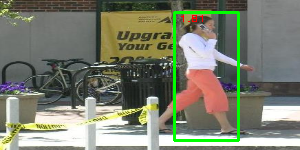

PennPed00081.png
sc:  [0.4006679774215013, 0.4125416861580026, 0.42382500006075496]


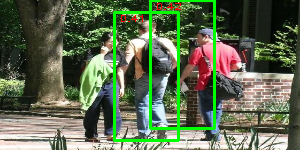

PennPed00071.png
sc:  [0.7483388557246194, 1.0333542513940763, 1.7706269023936754]


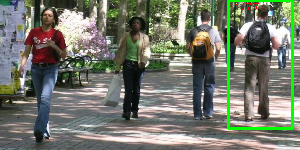

PennPed00005.png
sc:  [0.4443341859484021, 0.5700945133391307, 1.041533693252552, 1.3451425170842377]


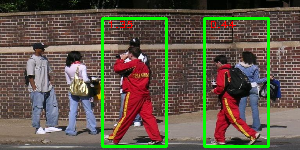

FudanPed00029.png
sc:  [0.401040483512081, 0.4960493753541685, 1.1455749138557736, 1.4957094140791596]


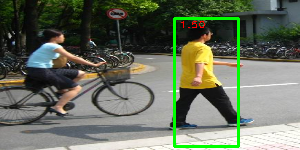

FudanPed00034.png
sc:  [0.49147572943165974, 0.5294234180564624, 0.6458293229810138, 0.6977322508881726, 1.0445970544263687]


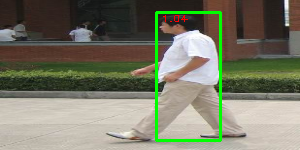

FudanPed00070.png
sc:  [1.0321537861268255]


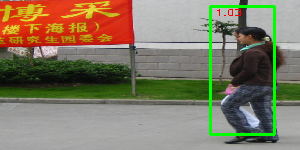

PennPed00035.png
sc:  [0.4208297793543506, 0.44172441049488265, 0.45446832406180626, 0.5352609149884652, 0.7251996087686862, 0.7708345504452213, 0.8270074960414316, 0.9491965166930315, 1.1262115817767908, 1.1890149888726507]


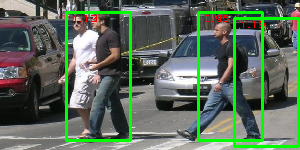

PennPed00062.png
sc:  [0.45628734378522273, 0.5201231105553014, 0.5706357415266389, 0.5865513261763732, 0.621079829257288, 0.6226981024209824, 0.6339583973883226, 0.6383465191422567, 0.6655989968439336, 0.6692575838041189, 0.6764632093049384, 1.1221976582850899, 1.2055442002945869, 1.275859079515869]


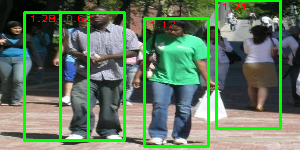

PennPed00068.png
sc:  [0.4778451735366408, 0.4937621809067362, 0.4958555920408886, 0.6513646956021669, 0.8655071810068843, 1.2524048340369682, 1.2791144263322454, 1.6574063847242941, 1.7353894712258215, 1.7429205562114833, 1.86821435865046, 1.961561681409406]


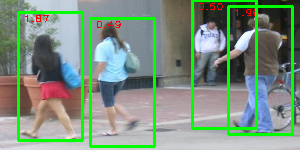

FudanPed00058.png
sc:  [0.4652913914625544]


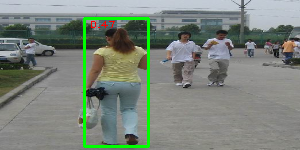

PennPed00004.png
sc:  [0.4167551213521866, 0.7624246415611219]


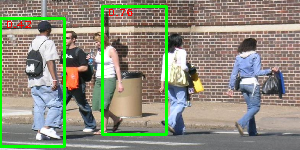

PennPed00047.png
sc:  [0.4672081613392821, 0.5313536609313575, 0.5409715190333316, 0.5898264872266835, 0.597853721208261, 0.6931794941208175, 0.7160291706156124, 0.7896089985899543, 0.7919302716883391, 0.8801018053002699, 0.9442612878275437, 1.008282961412835, 1.0259753966675627, 1.0291916209033105, 1.1901554630720073, 1.3286041108125213, 1.5801485246683318, 1.800233166428694, 1.8656563757486704, 1.9719191761182913, 2.0875101447429483]


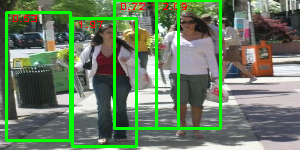

PennPed00045.png
sc:  [0.44623111809928984, 0.45789374470470634, 0.5571831412863241, 0.6594589553178397, 0.7381780667559718, 0.7599140392406859, 0.7739989450050594, 0.8108754389095952, 0.8929645350628009, 0.8942878599673788, 0.9189932791132273, 0.9431811745165889, 1.000904456690468, 1.0909873296098462, 1.4519016009200771, 1.8972241419744837]


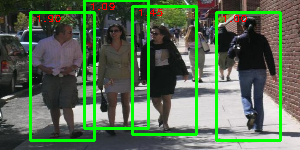

FudanPed00039.png
sc:  [0.4034405449664956, 0.43607710211138506, 0.5053076336652104]


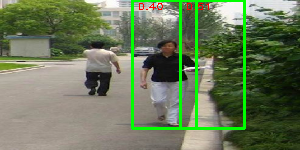

PennPed00088.png
sc:  [0.40640955429280445, 0.4781545051454624, 0.555296805718058, 0.6690648074795563, 0.7460392033008191, 0.8564932820275762, 1.0589643400690099]


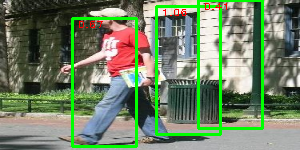

PennPed00087.png
sc:  [0.4104635932354418, 0.42575308022685265, 0.47409490360076545, 0.48797222543985985, 0.5328677490355919, 0.7432441928356129, 0.7751131414441564, 0.7814418214856534, 0.8050603431822648, 1.3241609280515236, 1.4720227170367313, 2.04236417725251]


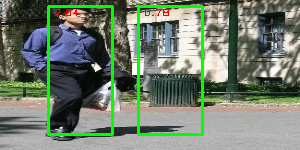

PennPed00001.png
sc:  [0.47637616518194814, 0.5142079232313183, 0.5381045763136293, 0.557933312134551, 0.5990178177205708, 0.7685419881874705, 0.7803396778379604, 0.8221309056829619, 0.8692199107932802, 0.9998556466142426, 1.0125700134046824, 1.1022026212632556, 1.1357278765957748, 1.2075199610200338, 1.354810197284865, 2.025560781296767]


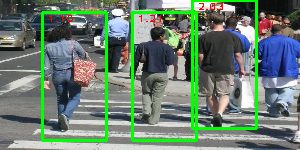

FudanPed00016.png
sc:  [0.45087938724176435, 0.8479383184596744]


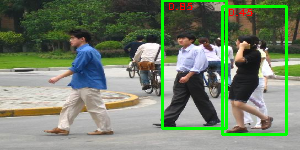

PennPed00026.png
sc:  []


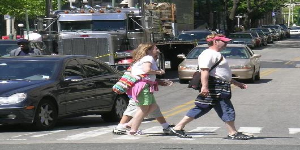

PennPed00017.png
sc:  [0.6758063923908827, 0.8025121813527382, 1.1544959845624603, 1.1670895717646568]


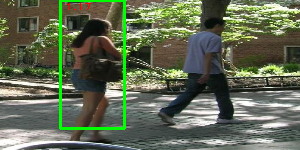

PennPed00060.png
sc:  [0.5328942052567226, 0.5335091039510121, 0.5683343833834639, 0.6404156777480171, 0.6454197664429718, 0.6590421389248645, 0.6676144377000485, 0.7613828035896871, 0.8945408209586426, 0.9358589463108372, 0.9846134791127662, 1.170955879926976, 1.17586064306313, 1.353035597158451, 1.6283987995864226, 2.093429453420773, 2.4425999805033847]


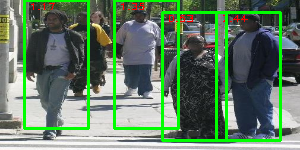

PennPed00051.png
sc:  [0.4939393789869354, 0.5201848362582772, 0.574540427466388, 0.7784432396151609, 0.8056146295369399, 1.03787241319163, 1.111464893323074, 1.1228897908801643]


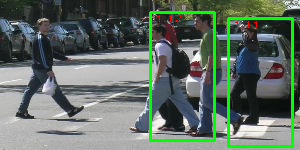

PennPed00083.png
sc:  [0.4881018296959253, 0.5163952870442755, 0.5729234136869826, 0.7214443310019335, 0.7661625879800836, 0.8448882186323944, 1.0474523025694165, 1.2492452233843014, 1.3413848118953404, 1.3434958568231266, 1.3843901766549984, 1.4323136143697406, 2.202231123336766, 2.243097156759047]


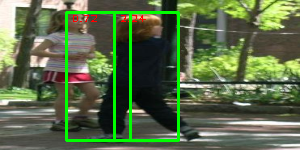

PennPed00052.png
sc:  [0.40224333636654996, 0.40818730467367026, 0.4288176018432063, 0.4427422078020612, 0.4529803962486322, 0.49087444178937834, 0.5104863888252257, 0.6317757684991686, 0.6372923308556327, 0.6751226433913914, 0.9015476276099029]


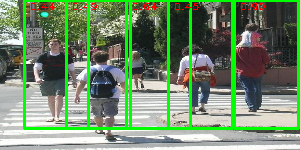

FudanPed00057.png
sc:  [0.42263690143388166, 0.46737321956369116, 1.1867448445669333]


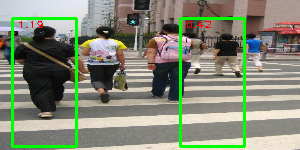

PennPed00070.png
sc:  [0.423759856981723, 0.43892707431209177, 0.6155765348086067, 0.6333038016445772, 0.6728759626988751, 0.8152264863409514, 0.8304463743010263, 0.858294216346449, 1.1026632429187475, 1.1517486992580546, 1.207889801096616, 1.3409817444240728]


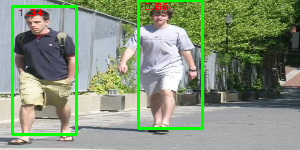

FudanPed00048.png
sc:  [0.4250999610053535, 0.48947552916226444, 0.5088882855144058, 0.5177535540950559, 0.591299764596772, 0.6132655390572984, 0.6540420582005771, 0.7690167343520259]


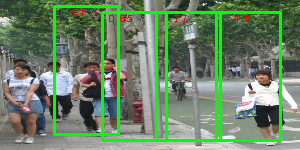

FudanPed00042.png
sc:  [0.5149504826342662, 0.6463495010875097, 0.7709558740815629, 0.806775010701788, 0.9066492876238058, 0.9179891952478015, 1.1382256912464594]


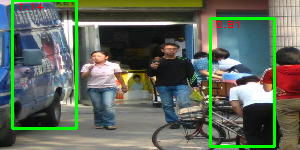

FudanPed00023.png
sc:  [0.6399680726807014, 0.6579450801089454, 1.6355010061012343]


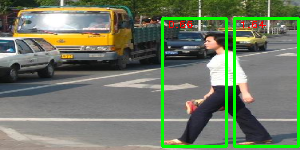

FudanPed00051.png
sc:  [0.7933069957905278]


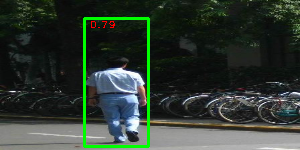

FudanPed00073.png
sc:  [0.463650195264249, 0.5806257791593895, 0.5916703609624016, 0.6124613869954622, 0.7358689714638263, 0.7844368378339827, 0.8917511114025195, 1.1895740370716998, 1.4525052839033403, 1.8040844195363888, 1.9209709862857927]


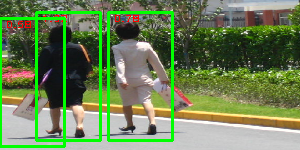

PennPed00094.png
sc:  [0.5232471669853632, 0.570938647388962, 0.5996925822586098, 0.9688680828707376, 0.9969684384890948]


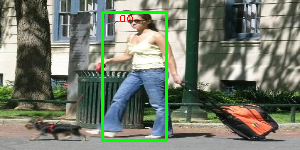

FudanPed00072.png
sc:  [0.6059682859858743, 0.7265253072493293, 0.7765739452062442, 1.1498238978153785, 1.2865336727153025, 1.643428216372579, 1.7282155557446495, 3.05175701658632]


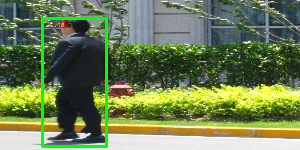

FudanPed00007.png
sc:  [0.4394129592274786, 0.4429851956266778, 0.4566701910979053, 0.4914561361543216, 0.5601275187880569, 0.5789297859731414, 0.8271756577421218, 1.2102684315852135, 1.8899727406862423]


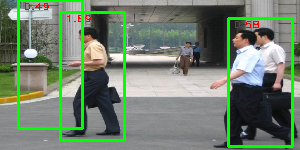

FudanPed00006.png
sc:  [0.40909080199017056, 0.6192650052992491, 0.7224590494925923]


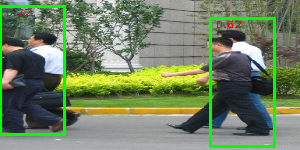

FudanPed00005.png
sc:  [0.6735667289438759]


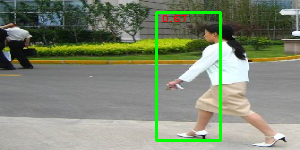

PennPed00074.png
sc:  [0.5122608892699977, 0.6837787552635824, 0.8505022434464381, 0.8921819224865734, 1.3315837339893584, 1.5709981238786055, 1.7448996438426039, 1.8201388054340066]


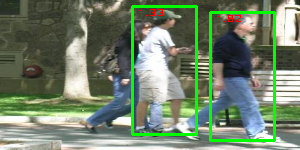

FudanPed00012.png
sc:  [0.4795098281268516, 0.5110041632364765, 0.5974537509194141, 0.7306768629354708, 0.8608976016947362]


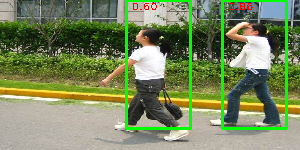

FudanPed00033.png
sc:  [0.42215130012126123, 0.45995853920969176, 0.6431982698966895, 0.8507491930189538]


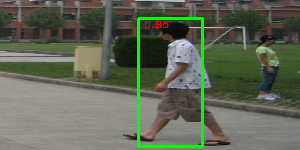

FudanPed00024.png
sc:  []


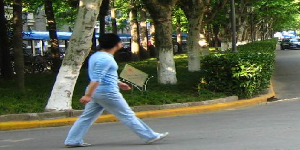

PennPed00025.png
sc:  [0.5122419532379597, 0.6615084849763114, 0.7954805549961893, 0.9673665129976635, 1.0303089609308955, 1.1720624517049587]


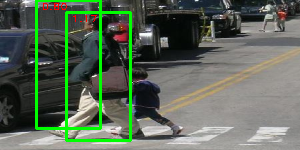

PennPed00067.png
sc:  [0.5605876036845286, 0.7324910947726763]


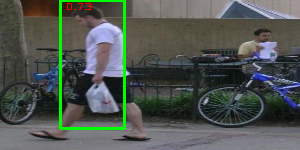

PennPed00034.png
sc:  [0.4368855939885089, 0.43723358680624325, 0.4610755070090574, 0.47916035872796015, 0.5003013953323511, 0.5221099754595356, 0.6355053196844412, 0.7995505394655492, 0.8930600405466723, 1.006131376737641, 1.2092763886631213]


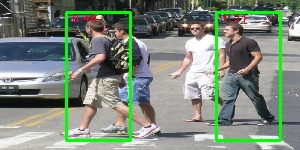

PennPed00048.png
sc:  [0.4032213917075499, 0.6237906854445957, 0.7482333898107237, 0.796172210973206, 0.926930599820542, 1.0317883526249267, 1.0934998116284578, 1.1041661414935802, 1.1155863690107934, 1.1436186774083987, 1.1795899072993623, 1.249054176242153, 1.6092608419916306, 1.6911943165474912]


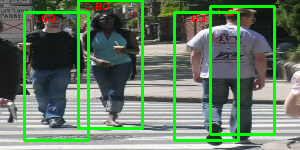

PennPed00050.png


In [ ]:
# test_dir = '/content/data/images/val/'
test_dir = '/content/PennFudanPed/PNGImages/'
# test_dir = '/content/good/'
test_list = os.listdir(test_dir)
count = 0
for file_name in test_list:
    if file_name.split('.')[0] == "":
        continue
    print(file_name)
    # file_name = '000000006074.jpg'
    # file_name = 'qq.jpg'
    count += 1
    if count > 50:
        break
    image = cv2.imread(test_dir + file_name)
    img_W = 300
    img_H = 150#int(image.shape[0]*img_W/image.shape[1])
    # img_H = 470
    # img_W = int(image.shape[1]*img_H/image.shape[0])
    image = cv2.resize(image,(img_W,img_H))
    size = (64,128)
    step_size = (6, 6)
    downscale = 1.5
    #List to store the detections
    detections = []
    #The current scale of the image 
    model = joblib.load('models_well.dat')
    scale = 0
    for im_scaled in pyramid(image, downscale = downscale, min_size=size):
        for (x, y, window) in sliding_window(im_scaled, step_size, size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)
            fd = hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            if pred == 1:
                if model.decision_function(fd) > 0.4:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                    int(size[0] * (downscale**scale)),
                    int(size[1] * (downscale**scale))))
                    # detections.append([x, y, model.decision_function(fd), size[0], size[1]])
        scale += 1
    clone = image.copy()
    rects = np.array([[x, y, x + w, y + h, cfd[0]] for (x, y, cfd, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    print ("sc: ", sorted(sc))
    sc = np.array(sc)
    pick = non_max_suppression_new(rects, probs = sc, overlapThresh = 0.5)
    for (x1, y1, x2, y2, cfd) in pick:
    # for (x, y, score, w, h) in detections:
    #     x1 = x
    #     y1 = y
    #     x2 = x + w
    #     y2 = y + h
    #     cfd = score[0]
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(clone,str("{:.2f}".format(cfd)),(x1+5,y1+10),1,0.75,(0,0,255),1)
    cv2_imshow(clone)

## Download PennFudan Dataset

In [ ]:
!wget 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'

--2021-06-30 10:18:19--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  97.5MB/s    in 0.5s    

2021-06-30 10:18:20 (97.5 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [ ]:
!unzip -qq 'PennFudanPed.zip'

In [ ]:
!zip -r 'penn.zip' 'PennFudanPed/'

## Hard Negative

In [ ]:
train_img_path = '/content/good/' #'/content/data/images/train/'
train_txt_path = '/content/drive/MyDrive/Study Documents/CS231 - CV/Project/data_root/labels/train/'
train_img_list = os.listdir(train_img_path)
count = 0
WINDOW_SIZE = (64, 128)
DOWN_SCALE = 1.5
STEP_SIZE = (47, 94)
for file_name in train_img_list:
    # file_name = '000000000328.jpg'
    if file_name.split('.')[0] == '':
        continue
    count += 1
    # if count > 5:
    #     break
    detection_list = []
    image = cv2.imread(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)
    scale = 0
    for im_scaled in pyramid(image, downscale = DOWN_SCALE, min_size=WINDOW_SIZE):
        # clone = im_scaled.copy()
        for (x, y, window) in sliding_window(im_scaled, STEP_SIZE, WINDOW_SIZE):
            if window.shape[0] != WINDOW_SIZE[1] or window.shape[1] != WINDOW_SIZE[0]:
                continue
            h = window.shape[0]
            w = window.shape[1]
            flag = True
            
            for bbox in new_labels:
                x_true = int(bbox[0] / (DOWN_SCALE ** scale))
                y_true = int(bbox[1] / (DOWN_SCALE ** scale))
                w_true = int(bbox[2] / (DOWN_SCALE ** scale))
                h_true = int(bbox[3] / (DOWN_SCALE ** scale))
                
                # cv2.rectangle(clone, (x_true, y_true), (x_true + w_true, y_true + h_true), (255, 0, 0), 2)

                iou = bb_intersection_over_union([x, y, x + w, y + h], [x_true, y_true, x_true + w_true, y_true + h_true])
                # print(iou, [x, y, x + w, y + h], [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
                if iou > 0.03:
                    flag = False
                    break
                    
            if flag == True:
                # cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
                detection_list.append((x, y, w, h))
            if 
            
        # cv2_imshow(clone)
        scale += 1
    i = 0
    for (x, y, w, h) in detection_list:

        cv2.imwrite(os.path.join('/content/data_neg_new/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(image[y:y+h, x:x+w],(64, 128)))
        i += 1
print(count)

In [ ]:
train_data = []
train_labels = []
pos_im_path = '/content/data_img/'
neg_im_path = '/content/data_neg_new/'
model = joblib.load('models_well.dat')
count = 0
# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.jpg")):
    fd = cv2.imread(filename, 0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(1)
    new_fd = fd.copy()
    fd = fd.reshape(1, -1)
    pred = model.predict(fd)
    if pred == 0:
        count += 1
        train_data.append(new_fd)
        train_labels.append(1)
print(count)
count = 0
# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(0)
    new_fd = fd.copy()
    fd = fd.reshape(1, -1)
    pred = model.predict(fd)
    if pred == 1:
        count += 1
        train_data.append(new_fd)
        train_labels.append(0)
print(count)

1907
571


In [ ]:
test_dir = '/content/data_img/'
test_list = os.listdir(test_dir)
count = 0
model = joblib.load('models_well.dat')
for file_name in test_list:
    image = cv2.imread(test_dir + file_name)
    # img_W = 350
    # image = cv2.resize(image,(img_W,int(image.shape[0]*img_W/image.shape[1])))
    fd = hog(image, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    new_fd = fd.copy()
    fd = fd.reshape(1, -1)
    pred = model.predict(fd)
    if pred == 0:
        # cv2_imshow(image)
        count += 1
        train_data.append(new_fd)
        train_labels.append(1)
print(count)

2024


In [ ]:
test_dir = '/content/data_neg_new/'
test_list = os.listdir(test_dir)
count = 0
model = joblib.load('models_well.dat')
for file_name in test_list:
    image = cv2.imread(test_dir + file_name)
    # img_W = 350
    # image = cv2.resize(image,(img_W,int(image.shape[0]*img_W/image.shape[1])))
    
    fd = hog(image, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    new_fd = fd.copy()
    fd = fd.reshape(1, -1)
    pred = model.predict(fd)
    if pred == 1:
        # if model.decision_function(fd) > 0.05:
        #     # cv2_imshow(image)
        count += 1
        train_data.append(new_fd)
        train_labels.append(0)
print(count)

851


In [ ]:
model_path = 'models_well_hard_hard.dat'
# train_data = np.float32(train_data)
# train_labels = np.array(train_labels)
# print('Train Data:',len(train_data))
# print('Train Labels (1,0)',len(train_labels))
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)
model = LinearSVC(max_iter=5000, C=0.5)
print('Training...')
model.fit(X_train, y_train)
joblib.dump(model, model_path)
print('Model saved : {}'.format(model_path))

Training...
Model saved : models_well_hard_hard.dat


In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.91311959185715
Precision: 0.5663189269746647
Recall: 0.3968668407310705


In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.906867403591257
Precision: 0.5137948984903696
Recall: 0.5154046997389033


In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9140699244735657
Precision: 0.5827036104114189
Recall: 0.36240208877284597


## Compare model

In [ ]:
!gdown --id 1paBE9NdjVzX-_Lr0oZoF_rpjVUl1OxxS -O data_neg.zip

Downloading...
From: https://drive.google.com/uc?id=1paBE9NdjVzX-_Lr0oZoF_rpjVUl1OxxS
To: /content/data_neg.zip
269MB [00:03, 88.0MB/s]


In [ ]:
!gdown --id 1dgznw6mZ4yVvwoOJkcSVhKoekhH391P3 -O data_pos.zip

Downloading...
From: https://drive.google.com/uc?id=1dgznw6mZ4yVvwoOJkcSVhKoekhH391P3
To: /content/data_pos.zip
25.1MB [00:00, 53.9MB/s]


In [ ]:
!unzip -qq 'data_neg.zip'
!unzip -qq 'data_pos.zip'

In [ ]:
train_data = []
train_labels = []
pos_im_path = '/content/data_img/'
neg_im_path = '/content/data_neg_new/'
# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.jpg")):
    fd = cv2.imread(filename, 0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(1)

# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(0)
train_data = np.float32(train_data)
train_labels = np.array(train_labels)
print('Train Data:',len(train_data))
print('Train Labels (1,0)',len(train_labels))
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)

Train Data: 64164
Train Labels (1,0) 64164


In [ ]:
model = joblib.load('models_well.dat')
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9383896103896104
Precision: 0.5950155763239875
Recall: 0.4185536888239591


In [ ]:
model = joblib.load('models_well_hard.dat')
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9677922077922078
Precision: 0.8322981366459627
Recall: 0.6851716581446311


In [ ]:
model = joblib.load('models_well_hard_hard.dat')
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9700779220779221
Precision: 0.7806086341118188
Recall: 0.8056975894813733


In [ ]:
model = joblib.load('models_well_hard_hard_hard.dat')
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9660779220779221
Precision: 0.8468992248062015
Recall: 0.6384222059897735


In [ ]:
model = joblib.load('7-26-6_model.sav')
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9336623376623376
Precision: 0.5818505338078291
Recall: 0.23886048210372535


In [ ]:
model = joblib.load('models_well.dat')
y_pred = model.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9712339137017411
Precision: 0.9218142548596112
Recall: 0.6576271186440678


In [ ]:
model = joblib.load('models_well_hard.dat')
y_pred = model.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9581422273678586
Precision: 0.767752059631228
Recall: 0.6030816640986133


In [ ]:
model = joblib.load('models_well_hard_hard.dat')
y_pred = model.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9634857728102596
Precision: 0.7460901563937442
Recall: 0.749768875192604


In [ ]:
model = joblib.load('models_well_hard_hard_hard.dat')
y_pred = model.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9549806296477713
Precision: 0.7625590382138256
Recall: 0.5473035439137134


In [ ]:
model = joblib.load('7-26-6_model.sav')
y_pred = model.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))
print("Precision:",metrics.precision_score(y_train, y_pred))
print("Recall:",metrics.recall_score(y_train, y_pred))

Accuracy: 0.9321147081088302
Precision: 0.5800653594771242
Recall: 0.21879815100154082


## Compare on PennFudanPed Dataset

In [ ]:
!gdown --id 1bpTQzPw-TlhfNXjVnNlq_ZCwa-4uiU1o -O annotation.zip

Downloading...
From: https://drive.google.com/uc?id=1bpTQzPw-TlhfNXjVnNlq_ZCwa-4uiU1o
To: /content/annotation.zip
100% 37.1k/37.1k [00:00<00:00, 28.6MB/s]


In [ ]:
!unzip -qq annotation.zip

In [ ]:
train_img_path = '/content/PennFudanPed/PNGImages/'
train_txt_path = '/content/Annotation/'
train_img_list = os.listdir(train_img_path)
count = 0
for file_name in train_img_list:
    if file_name.split('.')[0] == '':
        continue
    count += 1
    # if count > 1:
    #     break
    img = cv2.imread(train_img_path + file_name)
    print(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)
    i = 0
    print(new_labels)
    for bbox in new_labels:
        cv2.imwrite(os.path.join('/content/pen_pos/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(img[bbox[2]:bbox[4], bbox[1]:bbox[3]], (64, 128)))
        i += 1
print(count)

In [ ]:
train_img_path = '/content/PennFudanPed/PNGImages/'
train_txt_path = '/content/Annotation/'
train_img_list = os.listdir(train_img_path)
count = 0
WINDOW_SIZE = (64, 128)
DOWN_SCALE = 1.5
STEP_SIZE = (9, 9)
for file_name in train_img_list:
    # file_name = '000000000328.jpg'
    if file_name.split('.')[0] == '':
        continue
    count += 1
    # if count > 1:
    #     break
    detection_list = []
    image = cv2.imread(train_img_path + file_name)
    with open(train_txt_path + file_name.split('.')[0] + '.txt', 'r') as txt:
        labels = txt.read().split('\n')
        new_labels = []
        for row in labels:
            if row:
                row = list(map(lambda x: int(float(x)), row.split()))
                new_labels.append(row)
    scale = 0
    for im_scaled in pyramid(image, downscale = DOWN_SCALE, min_size=WINDOW_SIZE):
        # clone = im_scaled.copy()
        for (x, y, window) in sliding_window(im_scaled, STEP_SIZE, WINDOW_SIZE):
            if window.shape[0] != WINDOW_SIZE[1] or window.shape[1] != WINDOW_SIZE[0]:
                continue
            h = window.shape[0]
            w = window.shape[1]
            flag = True
            
            for bbox in new_labels:
                xmin_true = int(bbox[1] / (DOWN_SCALE ** scale))
                ymin_true = int(bbox[2] / (DOWN_SCALE ** scale))
                xmax_true = int(bbox[3] / (DOWN_SCALE ** scale))
                ymax_true = int(bbox[4] / (DOWN_SCALE ** scale))
                
                # cv2.rectangle(clone, (xmin_true, ymin_true), (xmax_true, ymax_true), (255, 0, 0), 2)

                iou = bb_intersection_over_union([x, y, x + w, y + h], [xmin_true, ymin_true, xmax_true, ymax_true])
                # print(iou, [x, y, x + w, y + h], [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
                if iou > 0.03:
                    flag = False
                    break
                    
            if flag == True:
                # cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
                detection_list.append((x, y, w, h))
            
        # cv2_imshow(clone)
        scale += 1
    i = 0
    for (x, y, w, h) in detection_list:
        cv2.imwrite(os.path.join('/content/pen_neg/', file_name.split('.')[0] + '_' + str(i) + '.jpg'), cv2.resize(image[y:y+h, x:x+w],(64, 128)))
        i += 1
print(count)

170


In [ ]:
print(len(os.listdir('/content/pen_pos')))

423


In [ ]:
train_data = []
train_labels = []
pos_im_path = '/content/pen_pos/'
neg_im_path = '/content/pen_neg/'
# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.jpg")):
    fd = cv2.imread(filename, 0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(1)

# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    train_data.append(fd)
    train_labels.append(0)
train_data = np.float32(train_data)
train_labels = np.array(train_labels)
print('Train Data:',len(train_data))
print('Train Labels (1,0)',len(train_labels))
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)

Train Data: 119637
Train Labels (1,0) 119637


### Result with step size 31 62

In [ ]:
model = joblib.load('models_well.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9453527096578868
Precision: 0.5691964285714286
Recall: 0.6028368794326241


In [ ]:
model = joblib.load('models_well_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9373297002724795
Precision: 0.508637236084453
Recall: 0.6264775413711584


In [ ]:
model = joblib.load('models_well_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9090221011201938
Precision: 0.3753501400560224
Recall: 0.6335697399527187


In [ ]:
model = joblib.load('models_well_hard_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9426279140175597
Precision: 0.5462184873949579
Recall: 0.6146572104018913


In [ ]:
model = joblib.load('7-26-6_model.sav')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9427792915531336
Precision: 0.5671641791044776
Recall: 0.4491725768321513


In [ ]:
!zip -r 'pen_pos.zip' 'pen_pos/'
!zip -r 'pen_neg.zip' 'pen_neg/'

### Result with step size 11 11

In [ ]:
model = joblib.load('models_well.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

In [ ]:
model = joblib.load('models_well_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

In [ ]:
model = joblib.load('models_well_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

In [ ]:
model = joblib.load('models_well_hard_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

In [ ]:
model = joblib.load('7-26-6_model.sav')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

### Result with step size 9 9

In [ ]:
model = joblib.load('models_well.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9700009194479968
Precision: 0.06936887921653971
Recall: 0.6028368794326241


In [ ]:
model = joblib.load('models_well_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9624781631100746
Precision: 0.057658833768494344
Recall: 0.6264775413711584


In [ ]:
model = joblib.load('models_well_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.930498090055752
Precision: 0.03179876601803512
Recall: 0.6335697399527187


In [ ]:
model = joblib.load('models_well_hard_hard_hard.dat')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9708367812633215
Precision: 0.07250418293363078
Recall: 0.6146572104018913


In [ ]:
model = joblib.load('7-26-6_model.sav')
y_pred = model.predict(train_data)
print("Accuracy:",metrics.accuracy_score(train_labels, y_pred))
print("Precision:",metrics.precision_score(train_labels, y_pred))
print("Recall:",metrics.recall_score(train_labels, y_pred))

Accuracy: 0.9788944891630516
Precision: 0.07655116841257051
Recall: 0.4491725768321513


## Calculate mAP

In [ ]:
!git clone https://github.com/Cartucho/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 33.62 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
!rm -r /content/mAP/input/ground-truth/
!mkdir /content/mAP/input/ground-truth/

In [ ]:
!cp -a /content/Annotation/. /content/mAP/input/ground-truth/

In [ ]:
!rm -r /content/mAP/input/detection-results/
!mkdir /content/mAP/input/detection-results/

In [ ]:
!rm -r /content/mAP/input/images-optional/
!mkdir /content/mAP/input/images-optional/

In [ ]:
test_dir = '/content/PennFudanPed/PNGImages/'
test_list = os.listdir(test_dir)
count = 0
for file_name in test_list:
    if file_name.split('.')[0] == "":
        continue
    print(file_name)
    # file_name = '000000006074.jpg'
    count += 1
    # if count > 50:
    #     break
    # print(test_dir + file_name)
    image = cv2.imread(test_dir + file_name)
    imgg = image.copy()
    im_w = image.shape[1]
    im_h = image.shape[0]
    img_W = 300
    img_H = 150#int(im_h*img_W/im_w)
    # img_H = 150
    # img_W = int(im_w*img_H/im_h)
    image = cv2.resize(image,(img_W, img_H))
    size = (64,128)
    step_size = (6, 6)
    downscale = 1.5
    #List to store the detections
    detections = []
    #The current scale of the image 
    model = joblib.load('models_well.dat')
    scale = 0
    for im_scaled in pyramid(image, downscale = downscale, min_size=size):
        for (x, y, window) in sliding_window(im_scaled, step_size, size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)
            fd = hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            if pred == 1:
                if model.decision_function(fd) > 0.4:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd), 
                    int(size[0] * (downscale**scale)),
                    int(size[1] * (downscale**scale))))
        scale += 1
    # clone = image.copy()
    rects = np.array([[x, y, x + w, y + h, cfd[0]] for (x, y, cfd, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    # print ("sc: ", sc)
    sc = np.array(sc)
    pick = non_max_suppression_new(rects, probs = sc, overlapThresh = 0.45)
    # detection_dir = '/content/mAP/input/detection-results/'
    # with open(detection_dir + file_name.split('.')[0] + '.txt', 'w') as txt:
    #     res = ""
    for (x1, y1, x2, y2, cfd) in pick:
        # cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)
        xmin = int(x1*im_w/img_W)
        ymin = int(y1*im_h/img_H)
        xmax = int(x2*im_w/img_W)
        ymax = int(y2*im_h/img_H)
        # res += ' '.join(str(i) for i in [0, cfd, xmin, ymin, xmax, ymax])
        # res += '\n'
        cv2.rectangle(imgg, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # txt.write(res)
    # if count % 10 == 0:
    #     print(count, end="\t")      
    # cv2_imshow(clone)
    cv2_imshow(imgg)
print(count)

In [ ]:
%cd /content/mAP
!python main.py

/content/mAP
44.27% = 0 AP 
mAP = 44.27%
<Figure size 640x480 with 1 Axes>


In [ ]:
%cd /content/

/content
